## RNN and LSTM
#### By MMA

In [1]:
import numpy as np
from utils import *
import random
from random import shuffle
import matplotlib.pyplot as plt

#### Dataset loading

In [2]:
data = open('data/dinos.txt', 'r').read()
data = data.lower()
chars = list(set(data))
data_size, vocab_size = len(data), len(chars)
print('There are %d total characters and %d unique characters in your data.' % (data_size, vocab_size))

There are 19909 total characters and 27 unique characters in your data.


#### Creating dictionaries 

In [3]:
char_to_ix = {ch: i for i, ch in enumerate(sorted(chars))}
ix_to_char = {i: ch for i, ch in enumerate(sorted(chars))}
print(ix_to_char)


{0: '\n', 1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z'}


#### Clipping Gradient

In [4]:
def clip(gradients, maxValue):
    
    dWaa, dWax, dWya, db, dby = gradients['dWaa'], gradients['dWax'], gradients['dWya'],\
                                gradients['db'], gradients['dby']
   
    # clip to mitigate exploding gradients, loop over [dWax, dWaa, dWya, db, dby]. (≈2 lines)
    for gradient in [dWax, dWaa, dWya, db, dby]:
        np.clip(gradient, a_min=-1 * maxValue, a_max=maxValue, out=gradient)
    
    gradients = {"dWaa": dWaa, "dWax": dWax, "dWya": dWya, "db": db, "dby": dby}
    
    return gradients


#### Sampling Function

In [5]:
def sample(parameters, char_to_ix, seed):

    # Retrieve parameters and relevant shapes from "parameters" dictionary
    Waa, Wax, Wya, by, b = parameters['Waa'], parameters['Wax'], parameters['Wya'], \
                           parameters['by'], parameters['b']
    vocab_size = by.shape[0]
    n_a = Waa.shape[1]

    # Step 1: Create the one-hot vector x for the first character (initializing the sequence generation). (≈1 line)
    x = np.zeros(vocab_size)
    x = np.reshape(x, (vocab_size, 1))
    # Step 1': Initialize a_prev as zeros (≈1 line)
    a_prev = np.zeros(n_a)
    a_prev = np.reshape(a_prev, (n_a, 1))
    
    # Create an empty list of indices, this is the list which will contain the list of indices of the characters to generate (≈1 line)
    indices = []

    # Idx is a flag to detect a newline character, we initialize it to -1
    idx = -1

    # Loop over time-steps t. At each time-step, sample a character from a probability distribution and append 
    # its index to "indices". We'll stop if we reach 50 characters (which should be very unlikely with a well 
    # trained model), which helps debugging and prevents entering an infinite loop. 
    counter = 0
    newline_character = char_to_ix['\n']

    while idx != newline_character and counter != 50:
        # Step 2: Forward propagate x using the equations (1), (2) and (3)
        a = np.tanh(np.matmul(Wax, x) + np.matmul(Waa, a_prev) + b)
        z = np.matmul(Wya, a) + by
        y = softmax(z)
        y = y.flatten()

        # for grading purposes
        np.random.seed(counter + seed)

        # Step 3: Sample the index of a character within the vocabulary from the probability distribution y
        idx = np.random.choice(27, p=y)

        # Append the index to "indices"
        indices.append(idx)

        # Step 4: Overwrite the input character as the one corresponding to the sampled index.
        x = np.zeros(27)
        x = np.reshape(x, (vocab_size, 1))
        x[idx] = 1

        # Update "a_prev" to be "a"
        a_prev = a

        # for grading purposes
        seed += 1
        counter += 1

    if counter == 50:
        indices.append(char_to_ix['\n'])

    return indices





In [6]:
def optimize(X, Y, a_prev, parameters, learning_rate = 0.01):
    # Forward propagate through time (≈1 line)
    loss, cache = rnn_forward(X, Y, a_prev, parameters, vocab_size)
    
    # Backpropagate through time (≈1 line)
    gradients, a = rnn_backward(X, Y, parameters, cache)
    
    # Clip your gradients between -5 (min) and 5 (max) (≈1 line)
    gradients = clip(gradients, 5)
    
    # Update parameters (≈1 line)
    parameters = update_parameters(parameters, gradients, learning_rate)
    
    return loss, gradients, a[len(X)-1]


### 3.2 - Training the model 

In [7]:
def model(data, ix_to_char, char_to_ix, num_iterations = 16000, n_a = 50, dino_names = 10, vocab_size = 27):
    # Retrieve n_x and n_y from vocab_size
    n_x, n_y = vocab_size, vocab_size
    
    # Initialize parameters
    parameters = initialize_parameters(n_a, n_x, n_y)
    
    # Initialize loss (this is required because we want to smooth our loss, don't worry about it)
    loss = get_initial_loss(vocab_size, dino_names)
    
    # Build list of all dinosaur names (training examples).
    with open("data/dinos.txt") as f:
        examples = f.readlines()
    examples = [x.lower().strip() for x in examples]
    
    # Shuffle list of all dinosaur names
    shuffle(examples)
    
    # Initialize the hidden state of your LSTM
    a_prev = np.zeros((n_a, 1))
    
    # Optimization loop
    iteration = []
    losses = []
    for j in range(num_iterations):
        # Use the hint above to define one training example (X,Y) (≈ 2 lines)
        index = j % len(examples)
        X = [None] + [char_to_ix[ch] for ch in examples[index]] 
        Y = X[1:] + [char_to_ix["\n"]]
        
        # Perform one optimization step: Forward-prop -> Backward-prop -> Clip -> Update parameters
        # Choose a learning rate of 0.01
        curr_loss, gradients, a_prev = optimize(X, Y, a_prev, parameters, learning_rate=0.01)
        
        # Use a latency trick to keep the loss smooth. It happens here to accelerate the training.
        loss = smooth(loss, curr_loss)

        # Every 2000 Iteration, generate "n" characters thanks to sample() to check if the model is learning properly
        if j % 100 == 0:
            losses.append(loss)
            iteration.append(j)
            print('Iteration: %d, Loss: %f' % (j, loss) + '\n')
            
            # The number of dinosaur names to print
            seed = 0
            for name in range(dino_names):
                
                # Sample indices and print them
                sampled_indices = sample(parameters, char_to_ix, seed)
                print_sample(sampled_indices, ix_to_char)
                
                seed += 1  # To get the same result for grading purposed, increment the seed by one. 
      
            print('\n')
        
    return parameters, iteration, losses

Iteration: 0, Loss: 32.978147

Nkzxwtdmfqoeyhsqwasjkjvu
Kneb
Kzxwtdmfqoeyhsqwasjkjvu
Neb
Zxwtdmfqoeyhsqwasjkjvu
Eb
Xwtdmfqoeyhsqwasjkjvu
B
Wtdmfqoeyhsqwasjkjvu



Iteration: 100, Loss: 33.583913

Okyvusbndrodygsqu
Koda
Kyvusbndrodygsqu
Oda
Yvusbndrodygsqu
Da
Vusbndrodygsqu
A
Usbndrodygsqu





Iteration: 200, Loss: 34.117208

Omxuusaocrqbwgsru
Koca
Lxuusaocrqbwgsru
Oca
Xuusaocrqbwgsru
Ca
Uusaocrqbwgsru
A
Usaocrqbwgsru



Iteration: 300, Loss: 34.364073

Omxuusaocrobvesru
Loca
Lxuusaocrobvesru
Oca
Xuusaocrobvesru
Ca
Uusaocrobvesru
A
Usaocrobvesru





Iteration: 400, Loss: 34.378026

Oovutsaperpeunspuashnlus
Log
Mwutsaperpeunspuashnlus
Of
Xutsaperpeunspuashnlus
Da
Utsaperpeunspuashnlus
A
Us



Iteration: 500, Loss: 34.230955

Onvusmembroluposoarincsoaltiyheaicaudam
Jog
Kwuslenarndunosoapkiisoaksaymaahaeuaal
Og
Xusielcroluposoarincsoaltiyheaicaudam
Ca
Uskenarndunosoapkiisoaksaymaahaeuaal
A
Us





Iteration: 600, Loss: 33.934476

Niwusdenasalunoslasapius
Ioh
Kxttraogos
Naa
Xuseelbpogurusiarhiisn
Ca
Useemcpogurusiarhiisn
A
Traogos



Iteration: 700, Loss: 33.589953

Oousos
Jnba
Lwttraoioravesauaurlisl
Oia
Xttraoioravesauaurlisl
Da
Usagmdoravesauaurlisl
A
Traoioravesauaurlisl





Iteration: 800, Loss: 33.198460

Njxusajohoraveseudus
Jndaaesomacourus
Lxttrcoipohurusacroresiaosawlianaltahdaol
Oia
Xusajohoraveseudus
Daaesomacourus
Usajohoraveseudus
A
Trcoipohurusacroresiaosawlianaltahdaol



Iteration: 900, Loss: 32.744764

Niwtsoerdoravhosoarhhhrranriyieamaitageaolafpbtolo
Ioia
Jxtsnbojopeveros
Nca
Xtsnbojopeveros
Daaerur
Ttpdlcoravhosoarhhhrranriyieamaitageaolafpbtolopra
A
Togmbpoiuruseasaurus





Iteration: 1000, Loss: 32.469113

Niwtsicmdoravesaucus
Iolaagpsagapsaurosrur
Ixtsicmdoravesaucus
Nca
Xtsicmdoravesaucus
Daaeslkaaosaurosrur
Tsicmdoravesaucus
A
Tohidoraveros



Iteration: 1100, Loss: 32.080642

Niwtsicierolurusaconelrqanpjyhealaktaheandagogsher
Ioka
Ixtsicierolurusaconelrqanpjyhealaktaheandagogshero
Nca
Xtsicierolurusaconelrqanpjyhealaktaheandagogsheros
Daaerur
Tsicierolurusaconelrqanpjyhealaktaheandagogsheros

A
Tohierolurusaconelrqanpjyhealaktaheandagogsheros





Iteration: 1200, Loss: 31.764770

Niwusalneromurushasaurus
Iola
Jxtrojleromurushasaurus
Nda
Xusalneromurushasaurus
Ec
Trojleromurushasaurus
A
Tokjdoraveros



Iteration: 1300, Loss: 31.418610

Nivusahjesanvisaugus
Ipca
Iwtroligoraverls
Nac
Xtroligoraverls
Ca
Trokigoraverls
A
Tolieronvfpos





Iteration: 1400, Loss: 31.148398

Mhusetanaurus
Inac
Ixtos
Mab
Xtos
Ca
Tos
A
Togharoiupros



Iteration: 1500, Loss: 30.754794

Mivtosaurus
Inacaisgibansaurushuraxanosausipeonasaurus
Iwtosaurus
Macaisfhacltisaurus
Xusanolnmaurusacrosaur
Ca
Tosaurus
A
Tojidoravgosebroresa





Iteration: 1600, Loss: 30.366657

Mhusgulurtnaveros
Hida
Ixtos
Macaisgecantis
Xusagiepnavfosh
Ba
Tos
A
Toin



Iteration: 1700, Loss: 30.163716

Mivtos
Hlecagpsahaus
Iwtos
Mca
Xusaljerolurtntasaurus
Ca
Tos
A
Toiresanunpruconggroansawjialdetageblebdohtomorna






Iteration: 1800, Loss: 29.864631

Mhusisaurus
Hiebaerus
Iwtos
Macaisheeaptmqagius
Xusakidmkaurus
Ba
Tos
A
Tolgbnnavgoshargelps



Iteration: 1900, Loss: 29.535456

Lhytosaurus
Hidaaerqcachushelgus
Hxtosaurus
Lacaisigachushelgus
Xuscapatolurusaconanos
Abamosanaus
Tosaurus
A
Tolehipaveris





Iteration: 2000, Loss: 29.341883

Lgwsludomoraverntareneseansavgeamaltacganabdojtomo
Hicaafron
Husisasauritgosiarelhos
Lacaislebansaurusapaeyalos
Xusbaneopaurus
A
Tos
A
Tohhapneuosaudus



Iteration: 2100, Loss: 29.114418

Lhxtprapdos
Hica
Hwtos
Macajrsafaus
Xusajnesaqtesaulus
A
Tos
A
Salicoraverltarangtoanthylcanagudalaneadoktonnhha






Iteration: 2200, Loss: 28.849253

Mivusaerasanveros
Hnecahosabaus
Iwusibleromveros
Mca
Xusicidosaurus
Ba
Tos
A
Tokldos



Iteration: 2300, Loss: 28.614464

Miwusagojopcurus
Inda
Iwtos
Mca
Xusdandopcurus
Ca
Tos
A
Togkdopcurus





Iteration: 2400, Loss: 28.283193

Lhvrosaurus
Hhacalosanaus
Hvrosaurus
Lacalosanaus
Xusedhapneupros
Aa
Tosaurus
A
Sdanerndurtos



Iteration: 2500, Loss: 28.160095

Mivtos
Inecalps
Iwtosaurus
Mccakrus
Xusjciipolvcors
Caagrsalatros
Tosaurus
A
Sickgopdurasocrlilto





Iteration: 2600, Loss: 27.903179

Nivushingosaurus
Ipedahus
Ivusiciesausaurur
Nca
Xusiciesausaurur
Caahusanaus
Trolomosaurus
A
Sicieronwgusiarinitobosaurur



Iteration: 2700, Loss: 27.818308

Nivusicherolurjps
Inecahps
Ivusleoloravhusacrrelps
Nca
Xusncherolvgosocrus
Caaertf
Toranernctisaunus
A
Togleronurtos





Iteration: 2800, Loss: 27.646488

Nivusegndopaurus
Inda
Jytorancor
Nca
Xusldngoravgosharilisfanrcyng
Ca
Torangos
A
Siciionavhorocona



Iteration: 2900, Loss: 27.509703

Mhytosaurus
Inacalosaurus
Iwtosaurus
Macalosaurus
Xusicherokuroseconggrobisaurup
Ca
Tosaurus
A
Shandoravgoseconggrobisaurup





Iteration: 3000, Loss: 27.399510

Livushenerlaunsaupus
Inca
Ivusichirictisaurus
Lecakton
Wusichipieupros
Ba
Torandos
A
Tokiepmcunosiariictoanthyihanaluden



Iteration: 3100, Loss: 27.133209

Livusarrascesaurupnggeskanthyndanaluialaphalomtons
Hicaaltopa
Ivusanparonvhosharengus
Lacalrus
Wtoraonosaurus
Acalrus
Torangosaurus
A
Sdandoraurusacrosauraptous





Iteration: 3200, Loss: 26.951518

Mgysrupidor
Incabasmur
Ivtromharkaurus
Macalpsanastiragmus
Wusmandoraveritaraphus
Baaerpeechresaurus
Toraperidthisocrisaur
A
Siciericsaurupkiiisebrustheamantadja



Iteration: 3300, Loss: 26.859646

Ngytos
Inecalps
Ivuseendor
Ncaahropa
Wuslaneronurus
Caagosateus
Torapcoraurus
A
Tolieps





Iteration: 3400, Loss: 26.708924

Mixusiangopauosaupus
Ingaagosas
Ivusjangopauosaupus
Macairomaansaurus
Xusmangoohunosiangiisianonyliaices
Ca
Torangopauosauqus
A
Toengopauosaupus



Iteration: 3500, Loss: 26.551155

Mevushanesausasaukus
Imacalosaurus
Ivushanesausasaukus
Macaisiiachus
Wuskbidosaurus
Baaerracarretengus
Tosaurus
A
Tojharneunosanrlemtochusonebegetan





Iteration: 3600, Loss: 26.479553

Ngyusndngopaurus
Imacaisiiabmurunanwiccyalosaurus
Ivusibiclohupros
Nca
Wusmbickoiunosdargheslansaurup
Ca
Toraperogveros
A
Toengopaurus



Iteration: 3700, Loss: 26.334713

Nivtosaurus
Ingaahosam
Jytosaurus
Ngaagosan
Xusmaneronus
Caaeron
Toraomos
A
Togngoravhosianilisacosaurur





Iteration: 3800, Loss: 26.229155

Nivusbblepnhurosgaranitochurylialbcs
Inecalosaurus
Kytrodonnolurorrasaurus
Necalosaurus
Wusmbicioithosiarcensiaosaurur
Ca
Trodomosaurus
A
Tojkeromurus



Iteration: 3900, Loss: 26.122507

Mevushanepoiunops
Inedagosaurus
Ivusicheorexasaunus
Macalosaurus
Xusndieopaupoptapglisadrusaphandhucemang
Baagosaurus
Torangopaupoos
A
Toingopaupoos





Iteration: 4000, Loss: 26.045318

Nivtroenchomvisaupus
Indaafrus
Ivusiandor
Ndabcosatersaurus
Xusncherokurosiarchisnantovel
Caaertga
Trodoniolurlns
A
Siandoraviris



Iteration: 4100, Loss: 25.974621

Ngytoraomus
Inecalosaurus
Ivusnchiorawgsaunus
Ndaahprodaosaurus
Xusndonosaurus
Caahosaurus
Trodonoqaurus
A
Tololopeverosaurus





Iteration: 4200, Loss: 25.865351

Nivstololopbwasfuconilsbanriylia
Inecalosaurus
Kxtosaurus
Necalosaurus
Wusodomoqaurus
Caagosaurus
Torangosaurus
A
Tololoravesaurus



Iteration: 4300, Loss: 25.750190

Nivrosaurus
Jlecalosaurus
Kxtosaurus
Necalosaurus
Wuslandor
Daagrona
Toraonosaurus
A
Tolidor





Iteration: 4400, Loss: 25.772500

Nivtrollgosaurus
Inedalosaurus
Kytrojidor
Necalosaurus
Xuspeonosaurus
Daahosaurus
Torapgor
A
Tomidor



Iteration: 4500, Loss: 25.724850

Nhytrodonlomurusacrosaurkkusulianakueilandaeratonp
Ince
Kwuslchepleurops
Necalskehaptosaurus
Wusnchernaups
Da
Tpraokopaupontanghisianrhylganabueikanda
A
Tolnboraveros





Iteration: 4600, Loss: 25.599403

Miusps
Inca
Iusrognasaurus
Macaisiecantisaurus
Wusmaneroitermocrigescansaururus
Caaertehantis
Torangosaurus
A
Toglcinavhoskariidroansaururus



Iteration: 4700, Loss: 25.475790

Mivusichenlaumusacrimesjansavhechalucemanebaraus
Inca
Ivuskbicinaverlubrengus
Macaisomabisaurus
Xusnchcinavermucongisbansavhecgbaua
Caadosaunus
Torapborawascsaphilus
A
Togkaribunoshaqelgus





Iteration: 4800, Loss: 25.392157

Miustolidor
Inca
Iustolidor
Macaiton
Xusogngronurusagrimerobitawataus
Caagosaurus
Torapgosaurus
A
Toheisaurus



Iteration: 4900, Loss: 25.331054

Nivusanons
Inca
Ivusanonopaurus
Nebalosaurus
Xusiangosaurus
Ca
Tosaurus
A
Toingosaurus





Iteration: 5000, Loss: 25.218667

Nivusarops
Imacalosaurus
Jyusiancholurhitas
Nebahosaurus
Xusianbosaurus
Daaeropa
Torasaurus
A
Toidarantes



Iteration: 5100, Loss: 25.166093

Ngyusiandor
Kkacajpsapersaurus
Lytosaurus
Ohaahus
Wuskanerncurosaurus
Caaerracarrathenus
Trodonlomurosaurus
A
Tojianonxatrulophisajrus





Iteration: 5200, Loss: 25.112899

Ngwtosaurus
Ingaahosaurus
Kwtqoinesaurus
Ngaahosaurus
Xusodonosaurus
Caagosaurus
Tosaurus
A
Tolonosaurus



Iteration: 5300, Loss: 25.104837

Onytos
Lola
Lytoranaromups
Ola
Xutollcinaunoseconidos
Edalptia
Trodia
A
Tolmanopterktalielto





Iteration: 5400, Loss: 25.029583

Onyusedolophylosocrilishansaururaelycelaolalodrolo
Knga
Lyusicheorevgoslarimdps
Oha
Xusicheopethtos
Daagosaurus
Trodolopetgosmarhigos
A
Todoloqeuroptaranitockussce



Iteration: 5500, Loss: 24.895561

Ngytrodomus
Imacalosaurus
Kytrodolopetdosiarangsoanthykabelatalialeceratonop
Nbaaerpfaanthus
Xuslandopaunosocongesmanthykabelatalialeceratonopl
Caadosaurus
Trodlarokursps
A
Slandonctisaurus





Iteration: 5600, Loss: 24.945093

Onyusaurus
Jlecaiser
Kxuslangosaurus
Ola
Xusmangosaurus
Caagrthacnus
Trognatopthusaloprishanqiykechamuon
A
Sndieopeveritaurus



Iteration: 5700, Loss: 24.902305

Onyuslapgosaurus
Jlecahus
Lyuspaneromx
Oja
Xustapborawhusiateoptochustelaleitala
Caaesteechusceliureeya
Trodiciolyisauhus
A
Toimasdeukoptasaurus





Iteration: 5800, Loss: 24.828353

Onyuskendoraviros
Loha
Lyussaurus
Ola
Xustendor
Ecaistehastes
Torasaurus
A
Tollepidus



Iteration: 5900, Loss: 24.822162

Onxtos
Lnedakropa
Lyuslaphoraurus
Ola
Xusraphosaurus
Ecalosaurus
Trognesaurus
A
Tolnesaurus





Iteration: 6000, Loss: 24.827049

Onuskoikaosaurus
Licaaeshacarops
Lytosaurus
Ogaagosaurus
Wuspanasaurus
Daadotedaniscelitiacycgosaurus
Trodiasaurus
A
Socharaitasauous



Iteration: 6100, Loss: 24.710760

Onvusaurus
Llee
Lvushaolosaurus
Olaahosaurus
Wusodon
Daagror
Tromichonurosebrinatrasaurus
A
Smbjerootesaurus





Iteration: 6200, Loss: 24.660601

Nivtrogiainctiritaranitochusung
Kledaiton
Lystollaroptirks
Necalrree
Xusraolorawerosaurus
Daahosalartitan
Troenchomygrnuangigrpantewcedia
Aaisphaclthuranus
Snendoraverosaurus



Iteration: 6300, Loss: 24.587325

Mhxrosaurus
Inacalosaurus
Iussmbiankaterit
Macakosaurus
Xusndichiateritargikus
Caaeropa
Torangosaurus
A
Sjbichiauphosaurus





Iteration: 6400, Loss: 24.564086

Onxushanesaurus
Llca
Lytromelosaurus
Olaaitop
Xusrapipletesaurus
Daagosaurus
Trognesaurus
A
Tolichicurosbardhesraosaurus



Iteration: 6500, Loss: 24.491446

Onyusehibor
Lode
Lyusiblerngyiros
Ofa
Yusoinatoptisaurus
Ecalosaurus
Trodon
A
Toinesaurus





Iteration: 6600, Loss: 24.468102

Nhysspanchoiter
Kicabcosaurus
Lytrodngopesaurulophitochonylebhalulanangalodromop
Nca
Xusichenmaurusanrangsiamusreiaeicreimaneceratops
Daaeron
Torangos
A
Sibicin



Iteration: 6700, Loss: 24.464282

Onyusaurus
Loda
Lyushandor
Ogaakus
Xusnenfpolurins
Edalosaurus
Trodon
A
Todon





Iteration: 6800, Loss: 24.361383

Phystomngosaurus
Loma
Mytromleroptisaurus
Peeaisphacisaurus
Xustephorhynosocriphosaurus
Eeaitria
Trokngronus
A
Trephosaurus
Altphacisaurus


Iteration: 6900, Loss: 24.373758

Onyusanops
Lnecaclraccosaurus
Lytosaurus
Oia
Xusndheosaurus
Ecabosaurus
Trodomnkatasaurus
A
Todomosaurus
Agps




Iteration: 7000, Loss: 24.219825

Onyusaurus
Kmacaisaurus
Lyuslbekopeurus
Ola
Xusodomosaurus
Caaerracdosaurus
Trodoniomunosialophos
Aagosaurus
Togodon
Alosaurus


Iteration: 7100, Loss: 24.302824

Onwusoflernctisaurus
Lledalosaurus
Lytroinerlethorratloptraptourbamaluiemangaloernesa
Olaalosaurus
Xusqeneoreurritargilus
Eealosaurus
Trognermathorratoratrasrgymeceletendangalncorerlol
A
Sognepneunortar
Alosalerthreliuricuonmujatrongidontiongorephus




Iteration: 7200, Loss: 24.249878

Phwusaurus
Loma
Lytrong
Pfcalosaurus
Xuspdonosaurus
Eealosaurus
Trolonosaurus
A
Sohngps
Alosaurus


Iteration: 7300, Loss: 24.292483

Onuspolnerneweoptar
Llecaisilachusheliurgax
Lustololopeurtosaurus
Ola
Xustandopeurusacrigishantixalapelucenaton
Ecakosaurus
Torangosaurus
Aagrona
Tokeipigusaurisaurus
Agosapasinogemus




Iteration: 7400, Loss: 24.265941

Onvusiangopeuosaurus
Loja
Lxusoenhopeuosaurus
Olaagosaurus
Xustaoiosaurus
Ecalosaurus
Troenhopgwdorocophiskansauruhiacs
A
Toloiosaurus
Ahrona


Iteration: 7500, Loss: 24.289044

Onvushamasaurus
Lledangteg
Lytrongasaurus
Oka
Xusraqgosaurus
Faaerosaurus
Trohidor
A
Sodolosaurus
Ahropechusokenwtonychosaurus




Iteration: 7600, Loss: 24.259195

Onvusibrinmethosiangikus
Lmee
Lvuskangondymusalroratraptotemanditanabonagoltopsa
Oma
Xustangosaurus
Egalosaurus
Trollernbvirosaurus
Aalosaurus
Tollernevhontarangus
Alton


Iteration: 7700, Loss: 24.172644

Ngytosaurus
Inacalrura
Kusosaurus
Ndaaisaurus
Wtrokidor
Caaerrae
Tosaurus
Aahus
Sichanoptosaurus
Akropabrus




Iteration: 7800, Loss: 24.134288

Onyusicherorus
Klecalosaurus
Lytosaurus
Okaagosaurus
Xusogophonyhosebrgimus
Ecaison
Trolichiburosaurus
Aadosaurus
Spendoraxaros
Agrorachusanglus


Iteration: 7900, Loss: 24.119353

Onvusaurus
Klebamosaurus
Lxtosaurus
Olaagosaurus
Xuspaogosaurus
Edalosaurus
Trolopronus
A
Tolonosaurus
Akprodandos




Iteration: 8000, Loss: 24.080356

Onyus
Loga
Lyusanonosaurus
Ola
Yuspdonniangorratops
Edalosaurus
Trohonggdyloscarosaurus
A
Tolonis
Agrus


Iteration: 8100, Loss: 23.977684

Omusisaurus
Lleaagps
Lyusochinilus
Ogaagrracarretan
Xuspblasaurus
Ecairopa
Trochesaurus
Aacosaurus
Slbicioitasaurus
Ahpsaiasthucenus




Iteration: 8200, Loss: 24.001323

Onyusfchenogurusmapilhtochustelamaguia
Logcalosaurus
Lwusochinidynosaurus
Ojaagtpodanthulenvilax
Xustaogosaurus
Eeaesiddentesaurus
Trodomnonusaurosaurus
Aaessalcisaurus
Togodon
Ajrolbantitan


Iteration: 8300, Loss: 23.961329

Nivusbaneshaurosharinitochoqyllaramucenatia
Jmacakrona
Kwtrohicosaurus
Ngaaiselaastesaurus
Xussaurus
Daaisig
Trodomosaurus
Aagssalastes
Tohiaosaurus
Aiton




Iteration: 8400, Loss: 23.930120

Onyusceratoptititaponitocitavifanbes
Koia
Lytrodon
Olaahus
Xustaneromuptosaurus
Dabarun
Trocepsanykurucongitocluskelamelue
Aagstehanus
Todomtiaumus
Aktria


Iteration: 8500, Loss: 23.900740

Onwusaurus
Lice
Lytosaurus
Ola
Xuspendopavisaurus
Edagosaurus
Trodom
Aafron
Todon
Alosaurus




Iteration: 8600, Loss: 23.913945

Onyusaurus
Lmcecersaumus
Lyusocidon
Oka
Xusraoereius
Daadropacosaurus
Trodon
A
Sodrisaurus
Aisthachus


Iteration: 8700, Loss: 23.913765

Onyusaurus
Logealosaurus
Lyusaurus
Oma
Xusrangosaurus
Daahosaurus
Trodon
A
Tolohopeus
Alosaurus




Iteration: 8800, Loss: 23.906098

Onvusaurus
Kidaahus
Lustolomopeus
Ola
Wtroeolopeus
Daagosaurus
Troeolopeus
Aahppelasops
Spenatops
Aitona


Iteration: 8900, Loss: 23.842288

Phvosaurus
Lica
Lustomicisaurus
Pedalosaurus
Xustarasaurus
Ecalosaurus
Troglbosaurus
A
Tolichkatasaurus
Agropachus




Iteration: 9000, Loss: 23.908986

Onvuscepernaviscocnideshamphykechaitan
Klecalosaurus
Lyusicheosaurus
Oka
Xustandor
Edaismedanosenenvngax
Trodongolupsis
A
Spendor
Agrteg


Iteration: 9100, Loss: 23.898281

Nixporangosaurus
Jibaagosaurus
Kwrosaurus
Nebaerona
Xusoeodon
Daaerona
Trodonosaurus
Aaforadantosaurus
Sichanolupnosaurus
Aisona




Iteration: 9200, Loss: 23.832290

Nixosaurus
Kiecaisieianosaurus
Kvrosaurus
Olaagosaurus
Xstomomosaurus
Edaerria
Troinisaurus
Aagosaurus
Skeripieurosaurus
Aisoka


Iteration: 9300, Loss: 23.795857

Ngyusicheroptosaurus
Kigaagps
Lyusicheroptosaurus
Nfa
Xusocelosaurus
Daaersagaptosaurus
Trohelosaurus
A
Sicheroptosaurus
Agrus




Iteration: 9400, Loss: 23.794542

Ngytotan
Jicabator
Kutosaurus
Ngaaeroracitatinevonax
Xutolodon
Daaerrae
Totaratops
Aaerradanosaurus
Tiengosaurus
Ahosaurus


Iteration: 9500, Loss: 23.774734

Nixspolonosaurus
Jicabasceia
Kytrokheosaurus
Oia
Yusoionosaurus
Daaeror
Trodon
A
Tolomis
Ahosaurus




Iteration: 9600, Loss: 23.691922

Olustolnctorsaurulophhus
Llebalosaurus
Lyusraomiraverataurus
Olaalosaurus
Xustarasaurus
Edalosaurus
Trodicholus
Aagptemastitalithelx
Tlengtinus
Akosaurus


Iteration: 9700, Loss: 23.704882

Ngytosaurus
Jicabaspegaptor
Kystohoeronykurocophosaurus
Ngabertacaropterewmedyeimucetosaurus
Xtosaurus
Daaersaichumuganuriaveoptagus
Troceiniaunorocophitochurymeanghucenatia
A
Todngromulusharcenrtaropulecheitancapa
Afppeechus




Iteration: 9800, Loss: 23.704355

Onyusaurus
Kidabasibachunopelus
Lyustangosaurus
Ogaaisig
Xustaomingyiros
Ecalosaurus
Trodomimathops
A
Todolosaurus
Agrondaroptenothegybanteisaurus


Iteration: 9900, Loss: 23.673395

Onyusidilus
Lnecalosaurus
Lytrraterhatasaurus
Olabastelasimus
Xutolonosaurus
Eeaislla
Trokilus
Aahusan
Tolomosaurus
Altrmacisaurus




Iteration: 10000, Loss: 23.658277

Onyushanchogus
Kidabasmbabltesaurus
Lyusrapkorax
Olaagrsaeeptosaurus
Xusraphorax
Daagosaurus
Trodolosaurus
Aaersalaptos
Spandondylus
Alpsalaptos


Iteration: 10100, Loss: 23.580777

Ngysspendondylus
Llca
Lwtosaurus
Ngaagosatersaurus
Xusodongolus
Edakptodan
Trodomingwanns
Aagosan
Todonipethosebrgimus
Alosan




Iteration: 10200, Loss: 23.671291

Ngytosaurus
Inbaahosaurus
Jwrosaurus
Nebahosaurus
Xusodonosaurus
Caagosaurus
Troeolosaurus
A
Skandosaurus
Aisonacosaurus


Iteration: 10300, Loss: 23.649617

Onyushanasegulosaurus
Llbaaerradantosaurus
Lxstogokosaurus
Olaagosaurus
Xuspcheopevesaurus
Ecaklona
Trodoloravipis
A
Treolopevesaurus
Ajpsagaptosaurus




Iteration: 10400, Loss: 23.612724

Onyuscepenomunsauirenismakulyelan
Llecalosaurus
Lyushalapheuroskangomosaurus
Ojaaerphaceratops
Xustaneosaurus
Ecalosaurus
Trochesaurus
A
Todongleveoscapkolus
Adrrceentosaurus


Iteration: 10500, Loss: 23.642529

Onxusidonosaurus
Llee
Lytrolophoeverataus
Ola
Xussangosaurus
Eeagosaurus
Trofngosaurus
Aahosaurus
Trephorax
Akropebptosaurus




Iteration: 10600, Loss: 23.676895

Ngytosaurus
Klcaafroodanthsaurus
Kvrosaurus
Necakosaurus
Xustaolosaurus
Ecalspegchuosaurus
Trocheosaurus
A
Spdidonaveritaurnitochustanamagtama
Agssakaptosaurus


Iteration: 10700, Loss: 23.614322

Meuskomomingyktos
Inde
Kussiandoraveros
Ndaakrosaurus
Wusochisaurus
Caadropcarsaurus
Troenasaurus
A
Slanesaurus
Akron




Iteration: 10800, Loss: 23.575651

Onyusanomingycosaurus
Klecalosaurus
Lytrong
Olaahus
Xusodonosaurus
Edaisilachusaleotonax
Trodonroptisaurus
Aahosaurus
Sodomoraxasis
Akrona


Iteration: 10900, Loss: 23.559830

Ngysroineosaurus
Inca
Kuspolnerostepsmarangrochusthiahelucheangalodor
Necalosaurus
Xuslaneroptor
Daaclpcaansaurus
Trocheniasaururus
Aacosaurus
Slanchoiteritaus
Agosaurus




Iteration: 11000, Loss: 23.550267

Onyusalolkonus
Lledalosaurus
Lxustaomingyerosaurus
Ojaaesraedosaurus
Xustarinonurosiarosauraptothia
Edalosaurus
Trodonjurus
Aahosaurus
Trephorex
Aitorabosaurus


Iteration: 11100, Loss: 23.516143

Phyusbaoforaxaurugosaurus
Llecalosaurus
Lyusiangsfcterosaurus
Peeaeptae
Yusodon
Ecalosaurus
Trocemathus
Aadosaurus
Trengosaurus
Agpsamansaurus




Iteration: 11200, Loss: 23.467664

Mevrosaurus
Imacalosaurus
Jvosichia
Macagosaurus
Xtkodia
Caacosaurus
Tnpanasaurus
Aacltag
Tidelosaurus
Afnsaurus


Iteration: 11300, Loss: 23.467676

Omustoigannhyksaurus
Jicabasidadis
Lvushandoraxhosaurus
Ofaahus
Xustaparomunosaurus
Ecaipsan
Trocheps
Aadrona
Tkgiaqolurops
Ahpsalaptosaurus




Iteration: 11400, Loss: 23.362778

Onyusaurus
Lodaa
Lyusedleriaursmtatandrobiphyleamakuaicana
Ola
Xuspanchiaumorrasaurus
Edaisphachusatroton
Troceinonus
A
Trchanlatasaurus
Akps


Iteration: 11500, Loss: 23.406335

Onyus
Klecalosaurus
Lytrodon
Oibaiptodanoptelotophya
Xusodon
Edadosaurus
Trochesaurus
A
Todolosaurus
Agosaurus




Iteration: 11600, Loss: 23.299621

Mewtosaurus
Inedalosaurus
Jwprodolosaurus
Macaiosaurus
Xusoeratogyenotaurus
Caaerracblops
Trodolosaurus
Aagosaurus
Todolosaurus
Alosaurus


Iteration: 11700, Loss: 23.376033

Ngysosaurus
Jiadantopaclus
Kusosaurus
Ndabasiceentosaurus
Xusnchapnitan
Cabarorachus
Trodon
A
Skanciomurusabranisanmus
Alnona




Iteration: 11800, Loss: 23.375660

Onyus
Loha
Lusptaomoravergtatorispanshyllaodosaurus
Ola
Xusokonosaurus
Eeahosaurus
Trodomosaurus
A
Triomosaurus
Alosaurus


Iteration: 11900, Loss: 23.395569

Niwtosaurus
Klecalosaurus
Lustolonlomuntisaurus
Ola
Xusteratops
Ecalosaurus
Trocheriateraterenitocjusthechelukelasaurus
Aahosaurus
Tolodon
Adromachus




Iteration: 12000, Loss: 23.401574

Onvus
Llee
Lvrosaurus
Olabhosaurus
Xusolomingumostarbimus
Edamosaurus
Trodon
A
Triomondyopos
Ahpoledosaurus


Iteration: 12100, Loss: 23.432541

Ngyusegicinaverataus
Klaca
Kvusianashcreshodon
Ngaagosaurus
Xusrandosaurus
Egagosaurus
Trodonathus
Aahus
Traolosaurus
Akrona




Iteration: 12200, Loss: 23.455520

Ngytosaurus
Klaaajosaurus
Kvspolonhiaulosia
Ngaagosaurus
Xusociankatdosaurus
Daaisolabnoptianticavantodauton
Trocharkatatot
Aahosaurus
Toimapteulosdankantoansaurur
Akpriaantatdiausaurus


Iteration: 12300, Loss: 23.405311

Ngytrong
Jiefalosaurus
Kussolophus
Ngaaishgdantosaurus
Wtrolonosaurus
Daalosaurus
Trokleroptisaurus
Aahsria
Toileronthoroclosaurans
Akrona




Iteration: 12400, Loss: 23.405123

Onyusanonosaurus
Llecalosaurus
Lyusegolionylusanophesobisaurus
Oia
Xusojichicurosaurus
Ecalosaurus
Troinesastis
Aacosaurus
Trerasaurus
Agrria


Iteration: 12500, Loss: 23.348174

Ngystongborawkustapnosaupus
Kilabasteedites
Lvosegnatikus
Ngaalosaurus
Xtosaurus
Egalosaurus
Trong
Aakosaurus
Tkengsaurus
Alosapeosaurus




Iteration: 12600, Loss: 23.370081

Onyusia
Kleaagosaurus
Lyustangosaurus
Ogaagsmeeanoponemus
Xustangosaurus
Daaiska
Trocelosaurus
A
Togolopewatotatops
Agrtae


Iteration: 12700, Loss: 23.268727

Nixosaurus
Kohaaersalepsaurus
Lutosaurus
Ngbaisig
Xuspangosaurus
Edaishhachurongithodychus
Trochepicurosaurus
A
Togodopeurus
Agrokachus




Iteration: 12800, Loss: 23.262121

Olvpsaurus
Lledaltor
Lvpsodngsaurus
Oicalus
Wusteratops
Eebersaurus
Trodon
A
Toiojosaurus
Aitpracosaurus


Iteration: 12900, Loss: 23.223901

Ngxtosaurus
Kndaagosaurus
Lvpsedomanfus
Ngbalosaurus
Xusolonosaurus
Ecamitol
Trodomosaurus
Aagosaurus
Trchaoravlosaurus
Agronderthollotia




Iteration: 13000, Loss: 23.237595

Onyus
Loha
Lytrokolsaurus
Olabastei
Xuspaqcmokykus
Eeagosaurus
Trodon
Aagrrhaceratops
Trinhoravermtaus
Akromabus


Iteration: 13100, Loss: 23.184493

Onwusaurus
Jicabasila
Kvosaurus
Olabbosaurus
Xsrocilosaurus
Edagosaurus
Trodonosaurus
Aagosaurus
Tididon
Alosaurus




Iteration: 13200, Loss: 23.239143

Ngysprandondylus
Klacaltor
Kyssranchiaukras
Ndaadrolacisaurus
Xuskararegveretasaurus
Caacrodacosaurus
Trocheriathors
Aacrodcarsaurus
Trandondylus
Aisracantholentodex


Iteration: 13300, Loss: 23.272339

Onyusaurus
Logeagrope
Lystoloptopteryx
Olaagosaurus
Xusojnerorumorucordosanosaurus
Edalosaurus
Trodoniceurosrangontochuspleanchuhamanfamumus
Aaispelaslisaurus
Trephosaurus
Agosaurus




Iteration: 13400, Loss: 23.282497

Nhytosaurus
Inecalptojantosaurus
Kustraphoraveriteratops
Necalosaurus
Xustereps
Dabaspegceratops
Trocheps
Aaersaocothurcethelya
Trephordus
Agrole


Iteration: 13500, Loss: 23.236782

Olustolilosaurus
Llecalosaurus
Lustolonholus
Olaberosaurus
Xustangosaurus
Egahosaurus
Trocheosaurus
Aakosaurus
Tohleosaurus
Ahosaurus




Iteration: 13600, Loss: 23.267645

Ngysos
Kleeahosaurus
Kwrosaurus
Ngaaischachynsaurus
Xproinasaurus
Efakosaurus
Trofoniraurus
Aalosaurus
Skeonosaurus
Aisrceerphomenus


Iteration: 13700, Loss: 23.294377

Ngysosaurus
Kolacerosaurus
Lxpprosaurus
Ngaaerrabaptor
Xusognatoptititan
Egagosaurus
Troinatorosaurus
Aajosaurus
Trephosaurus
Akropacisaurus




Iteration: 13800, Loss: 23.278406

Mivuscephorex
Infa
Kyspodonkonyirosaurus
Mebaeosaurus
Xtroenesaurus
Edaeosaurus
Trodonosaurus
Aahosaurus
Sochisaurus
Agosaurus


Iteration: 13900, Loss: 23.246274

Ngyskogia
Jidabasia
Kxprokekosaurus
Nebainona
Xsplanglomterosaurus
Daaeropaantesaurus
Troices
Aaeropachus
Sicheptetchosaurus
Ajloma




Iteration: 14000, Loss: 23.245061

Ngystog
Jlecalosaurus
Kusosaurus
Ngabeosaurus
Wurocheosaurus
Edanosaurus
Trocheosaurus
Aagosaurus
Toencincs
Ahosaurus


Iteration: 14100, Loss: 23.272506

Omvosaurus
Llee
Lystolommodus
Olabeskhebntiten
Xusolominaurus
Eeahosaurus
Troinasaurus
Aaerria
Triolosaurus
Aisphadosaurus




Iteration: 14200, Loss: 23.174705

Olustollerhathosaurus
Kldaalosaurus
Lwtotapnosaurus
Ofaadroracrus
Xuspancjomurosaurus
Edaesmeiahonsaurus
Trocenosaurus
Aacosaurus
Treonnosshoro
Agosaurus


Iteration: 14300, Loss: 23.152845

Mevrrodillojuporochus
Jicaceron
Kustolophusacrosaurus
Macagps
Wurocephodyltos
Daacosaurus
Trocenltaurus
Aaciraebptosaurus
Trephopaurosaurus
Aerria




Iteration: 14400, Loss: 23.095470

Mgyusaurus
Jjcaalosaurus
Kyusaurus
Macalosaurus
Xustandon
Daalosaurus
Trodon
Aagosaurus
Treonis
Agpsan


Iteration: 14500, Loss: 23.111581

Ngytropigsanthorratiosaurus
Indaberthachus
Kytronomoraverrtasaurus
Ngaaisrna
Xustangosaurus
Eeairria
Trohianiaterotausaururus
Aagropachus
Trchapriterntatilitochustonangitan
Alronechusaurus




Iteration: 14600, Loss: 23.096725

Mevusaurus
Inbaalus
Iustrephosaurus
Macalosaurus
Xustandopaverhuchibesmamurymachahua
Daalosaurus
Trodon
Aadrrahanus
Treonosaurus
Alosaurus


Iteration: 14700, Loss: 23.005313

Mevrosaurus
Inbaakosaurus
Kysosaurus
Macalosaurus
Xusogonosaurus
Eeagosaurus
Trodondosteros
A
Sokolosaurus
Alosaurus




Iteration: 14800, Loss: 23.123995

Mewtosaurus
Imacallthaclus
Ivuscepasceueoscaphikus
Macagnonaclus
Xrlichasausaurupsaurus
Caadosaunus
Trochasausaurus
A
Tochasaus
Agnodecites


Iteration: 14900, Loss: 23.077141

Ngytosaurus
Jicabatorahosaurus
Lystoincosaurus
Ngaahotelaspksajitilawa
Xusolonisaurus
Daaissan
Trodontoosaurus
Aaesteianshuellus
Treposaurus
Agosaurus




Iteration: 15000, Loss: 23.128493

Ngytosaurus
Jolaagosaurus
Kustolong
Necanosaurus
Xussaurus
Daalosaurus
Trochesaurus
Aalosaurus
Tollerkauprosaurus
Agosaurus


Iteration: 15100, Loss: 23.130616

Ngytosaurus
Kola
Lvotom
Ngaaesaurus
Xustaodon
Egagosaurus
Trodon
Aaisaurus
Traolosaurus
Alosaurus




Iteration: 15200, Loss: 23.211378

Ngytosaurus
Kolebesra
Kyrspandynathospandonsocosaurus
Ngcalosaurus
Wusraonineuroshangilus
Egagosaurus
Trodon
A
Trephosaurus
Agrrhados


Iteration: 15300, Loss: 23.204791

Mgwusaurus
Inedalosaurus
Iutosaurus
Macalsica
Wuspandtonylus
Caakron
Trognatoptitosaurus
A
Toholosaurus
Aissagnosaurus




Iteration: 15400, Loss: 23.155657

Mgyushandosaurus
Inecaesteia
Kvushandosaurus
Ngaafropa
Wuromeitheusistaplilus
Edaispha
Trongerngushis
A
Todolosaurus
Agrus


Iteration: 15500, Loss: 23.148192

Ngystononosaurus
Jiecanrria
Kustonnbordyntosaurus
Ngaaersalchretan
Wusparchiaurus
Edalosaurus
Trongernatlosaurus
Aadropcarthranius
Tokleriasaurus
Aitorachus




Iteration: 15600, Loss: 23.162130

Onyvromelus
Klecanotelatops
Lutrodon
Olabestelatops
Xuspeogosaurus
Efaisina
Trodon
Aaersalersaurus
Trerasaurus
Akrona


Iteration: 15700, Loss: 23.106350

Omustolimis
Llebaeosaurus
Lyrspandos
Oldalosaurus
Yuslengropterrochellos
Eeaeosaurus
Trodelosaurus
Aaersaterylomelus
Treolis
Alosaurus




Iteration: 15800, Loss: 23.075693

Meusosaurus
Jiabalosaurus
Kxus
Macalosaurus
Xusolia
Egagosaurus
Trodleramunrnochelisaurus
Aadrs
Todon
Akosaurus


Iteration: 15900, Loss: 23.073658

Mevusarngsaurus
Imacaisauronsaurus
Justognatoptlops
Macaerradantosaurus
Xuspcheoraviosaurus
Daadosaurus
Troceratosaurus
Aacosaurus
Tkendoraviosaurus
Agosaurus




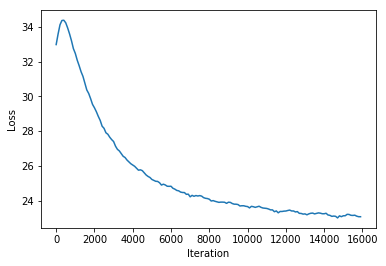

In [8]:
parameters, iteration, losses = model(data, ix_to_char, char_to_ix)
plt.plot(iteration, losses)
plt.ylabel('Loss')
plt.xlabel('Iteration')
plt.show()
